In [20]:
#vårt projekt

from typing import Tuple

from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch.utils.data import dataset
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR
import random
import numpy as np
import math

import matplotlib.pyplot as plt
from tqdm import tqdm
from torchtext.data.metrics import bleu_score

In [21]:
print(torch.__version__)

2.2.2


In [22]:
# pip install sentencepiece
# pip install tqdm
#conda install pytorch torchvision torchaudio -c pytorch
#python -m pip uninstall pytorch

In [23]:
import sentencepiece as spm

In [24]:
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

In [25]:
if torch.cuda.is_available():
    device = 'cuda'

else:
    device = 'cpu'
DEVICE = torch.device(device)
DEVICE


device(type='cpu')

In [26]:
#Alice paths
data_path = '/Users/alicetottie/Downloads/projekt_data/train_paracrawl.en'
data_path_2 = '/Users/alicetottie/Downloads/projekt_data/train_paracrawl.sv'

#Maja paths
# data_path = '/Users/majarygard/Documents/LTH/Projekt i Data/train_paracrawl.en'
# data_path_2 = '/Users/majarygard/Documents/LTH/Projekt i Data/train_paracrawl.sv'

#Pernilla paths
#data_path = 'C:\\Users\\nilla\\Plugg\\project-data\\train_paracrawl.en\\train_paracrawl.en'
#data_path_2 = 'C:\\Users\\nilla\\Plugg\\project-data\\train_paracrawl.sv\\train_paracrawl.sv'


In [27]:
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

with open(data_path_2, "r", encoding="utf-8") as f:
    lines2 = f.read().split("\n")    

In [28]:
len(lines)



4960283

In [29]:
len(lines2)

4960283

In [30]:
num_samples = 1000
input_texts = []
target_texts = []

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text= line.split("\t")
    input_texts.append(input_text)

with open("input_texts.txt", "w", encoding='utf-8') as f:
    for input_text in input_texts:
        f.write('\t'.join(input_text) + '\n')
    
for line in lines2[: min(num_samples, len(lines2) - 1)]:
    target_text= line.split("\t")
    target_texts.append(target_text)  

with open("input_texts.txt", "a", encoding='utf-8') as f:
    for target_text in target_texts:
        f.write('\t'.join(target_text) + '\n') 

In [31]:
input_texts[50]



["!!*smile_BAba!!* hasn't favorited any games yet!"]

In [32]:
target_texts[50]

['!!*smile_BAba!!* har inte favoritmarkerat några spel ännu!']

In [33]:
TRAIN_PERCENTAGE = 0.8
train_val = int(TRAIN_PERCENTAGE * num_samples)
train_val

800

In [34]:
text_pairs = list(zip(input_texts, target_texts))
random.shuffle(text_pairs)
input_texts, target_texts = zip(*text_pairs)
input_texts, target_texts = list(input_texts), list(target_texts)


In [35]:
train_input_texts = input_texts[:train_val]
train_target_texts = target_texts[:train_val]

val_input_texts = input_texts[train_val:]
val_target_texts = target_texts[train_val:]

In [36]:
spm.SentencePieceTrainer.train('--input=input_texts.txt --model_prefix=m --vocab_size=35000 --model_type=bpe --pad_id=3')

# makes segmenter instance and loads the model file (m.model)
sp = spm.SentencePieceProcessor()
sp.load('m.model')

sp.SetEncodeExtraOptions("bos:eos")
sp.SetDecodeExtraOptions("bos:eos")

# encode: text => id
print(sp.encode_as_pieces('This is a test'))
print(sp.encode_as_ids('This is a test'))

# decode: id => text
print(sp.decode_pieces(['▁This', '▁is', '▁a', '▁t', 'est']))
print(sp.decode_ids([1, 665, 64, 5, 4, 134, 2]))

['<s>', '▁This', '▁is', '▁a', '▁test', '</s>']
[1, 1221, 120, 6, 2384, 2]
This is a test
honomill terte


In [37]:
UNK_IDX, BOS_IDX, EOS_IDX, PAD_IDX = 0, 1, 2, 3

In [38]:
def text2codes(texts, sp):
    codes = []
    for text in texts:
        text_l = text[0]
        code = sp.encode_as_ids(text_l)
        n_code = torch.tensor(code)
        codes.append(n_code)

    return codes



In [39]:
train_input_texts[:3], train_target_texts[:3]

([["!!TheM!Z!! hasn't added any friends yet!"],
  ['" Memory / Summerday" gouache/wood/butterfly 48x75 / 48x92cm 2006'],
  ['" child safety in Egypt "" harmfulness of the sun in Egypt on baby skin "" what medications the child in Egypt "" where on holiday with his family to Egypt "" pediatrician "" in which the child free hotels "']],
 [['!!TheM!Z!! har inte lagt till några vänner ännu!'],
  ['"Hågkomst / Sommardag" gouache/trä 48x75 /48x92cm2006'],
  ['" barnsäkerhet i Egypten "" skadlighet solen i Egypten på baby hud "" vilka mediciner barnet i Egypten "" där på semester med sin familj till Egypten "" barnläkare "" där barnet hotellsökningen "']])

In [40]:
text2codes(train_input_texts[:3], sp)[:3]

[tensor([    1,   311,  3644, 34937, 34980,   592,   611, 34958, 34896,  3256,
           403,  1955,   526, 34937,     2]),
 tensor([    1,     8, 15248,   439, 17385, 34907,  8869, 34964,  2599, 34964,
         12477,  4537, 34954,  2461,   439,  4537, 34954,  1787,   987,  4935,
             2]),
 tensor([    1,     8,  4110, 10400,    37,   158,    75, 18243,    44,    29,
          2646,    37,   158,   153,  4981,  3220,    75,   482,  5682,    29,
          4110,    37,   158,    75,  1312,   153,  2875,   202,   410,  3317,
            61,   158,    75, 18539,    75,    37,   382,    29,  4110,  3979,
          1948,     8,     2])]

In [41]:
def codes2text(codes):
    texts = []
    for code in codes:
        code_l = list(code)
        for p in code_l:
            texts.append(sp.id_to_piece(p.item()))
    return texts

In [42]:
codes2text(text2codes(train_input_texts[:3], sp)[:3])

['<s>',
 '▁!!',
 'TheM',
 '!',
 'Z',
 '!!',
 '▁hasn',
 "'",
 't',
 '▁added',
 '▁any',
 '▁friends',
 '▁yet',
 '!',
 '</s>',
 '<s>',
 '▁"',
 '▁Memory',
 '▁/',
 '▁Summerday',
 '"',
 '▁gouache',
 '/',
 'wood',
 '/',
 'butterfly',
 '▁48',
 'x',
 '75',
 '▁/',
 '▁48',
 'x',
 '92',
 'cm',
 '▁2006',
 '</s>',
 '<s>',
 '▁"',
 '▁child',
 '▁safety',
 '▁in',
 '▁Egypt',
 '▁""',
 '▁harmfulness',
 '▁of',
 '▁the',
 '▁sun',
 '▁in',
 '▁Egypt',
 '▁on',
 '▁baby',
 '▁skin',
 '▁""',
 '▁what',
 '▁medications',
 '▁the',
 '▁child',
 '▁in',
 '▁Egypt',
 '▁""',
 '▁where',
 '▁on',
 '▁holiday',
 '▁with',
 '▁his',
 '▁family',
 '▁to',
 '▁Egypt',
 '▁""',
 '▁pediatrician',
 '▁""',
 '▁in',
 '▁which',
 '▁the',
 '▁child',
 '▁free',
 '▁hotels',
 '▁"',
 '</s>']

In [43]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super().__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)
                        * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)
        self.emb_size = emb_size

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding * math.sqrt(self.emb_size)
                            + self.pos_embedding[:token_embedding.size(0), :])

In [44]:
pe = PositionalEncoding(10, 0.1)

In [45]:
torch.zeros(1, 5, 10)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [46]:
pe(torch.zeros(1, 5, 10))

tensor([[[0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 0.0000],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 0.0000, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111]]])

In [47]:
# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super().__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)

        self.emb_size = emb_size
        # Same source and target embs Sect. 3.4
        self.embedding = nn.Embedding(
            vocab_size, emb_size, padding_idx=3)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        # Bias to be compatible with embeddings
        self.generator = nn.Linear(emb_size, vocab_size, bias=False)
        self.generator.weight = self.embedding.weight  # Shared weights Sect. 3.4

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.embedding(src))
        tgt_emb = self.positional_encoding(self.embedding(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
            self.embedding(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
            self.embedding(tgt)), memory,
            tgt_mask)


In [48]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float(
        '-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [49]:
generate_square_subsequent_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [50]:
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),
                           device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1).type(torch.float32)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


In [51]:
src = pad_sequence(text2codes(
    train_input_texts[:3], sp), padding_value=PAD_IDX)
tgt = pad_sequence(text2codes(
    train_target_texts[:3], sp), padding_value=PAD_IDX)

In [52]:
train_input_texts[:3], train_target_texts[:3]

([["!!TheM!Z!! hasn't added any friends yet!"],
  ['" Memory / Summerday" gouache/wood/butterfly 48x75 / 48x92cm 2006'],
  ['" child safety in Egypt "" harmfulness of the sun in Egypt on baby skin "" what medications the child in Egypt "" where on holiday with his family to Egypt "" pediatrician "" in which the child free hotels "']],
 [['!!TheM!Z!! har inte lagt till några vänner ännu!'],
  ['"Hågkomst / Sommardag" gouache/trä 48x75 /48x92cm2006'],
  ['" barnsäkerhet i Egypten "" skadlighet solen i Egypten på baby hud "" vilka mediciner barnet i Egypten "" där på semester med sin familj till Egypten "" barnläkare "" där barnet hotellsökningen "']])

In [53]:
create_mask(src, tgt)

(tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]),
 tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
         [0., 0., -inf,  ..., -inf, -inf, -inf],
         [0., 0., 0.,  ..., -inf, -inf, -inf],
         ...,
         [0., 0., 0.,  ..., 0., -inf, -inf],
         [0., 0., 0.,  ..., 0., 0., -inf],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  

In [54]:
VOCAB_SIZE = 35000 #max(token2idx.values()) + 1  # or len(token2idx)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6


In [55]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [56]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=0.1) #SMOOTHING

optimizer = torch.optim.Adam(
            transformer.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9 #vilken learning rate behövs??
        )
lr_scheduler = LambdaLR( 
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=transformer.emb_size, factor=1.0, warmup=4000
        ),
    )#lagt till!!

/Users/alicetottie/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [57]:
from torch.utils.data import Dataset, DataLoader

In [58]:
class PairDataset(Dataset):
    def __init__(self, input_texts, target_texts, token2idx):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.token2idx = token2idx

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        src_batch = text2codes([input_texts[idx]], self.token2idx)
        tgt_batch = text2codes([target_texts[idx]], self.token2idx)

        return src_batch[0], tgt_batch[0]

    def collate(self, batch):
        src_batch, tgt_batch = list(zip(*batch))
        src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
        tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)

        return src_batch, tgt_batch

In [59]:
train_dataset = PairDataset(train_input_texts, train_target_texts, sp)
train_dataloader = DataLoader(train_dataset, batch_size=32,
                              shuffle=True, collate_fn=train_dataset.collate)

In [60]:
val_dataset = PairDataset(val_input_texts, val_target_texts, sp)
val_dataloader = DataLoader(
    val_dataset, batch_size=32, collate_fn=val_dataset.collate)

In [61]:
def train_epoch(model, optimizer, dataloader):
    model.train()
    losses = 0
    sent_cnt = 0
    correct, total = 0, 0
    for src_batch, tgt_batch in tqdm(dataloader):
        src = src_batch.to(DEVICE)
        tgt = tgt_batch.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input)

        logits = model(src,
                       tgt_input,
                       src_mask,
                       tgt_mask,
                       src_padding_mask,
                       tgt_padding_mask,
                       src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(
            logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        lr_scheduler.step() #LAGT TILL
        losses += loss.item()

        with torch.no_grad():
            sent_cnt += tgt_out.size()[-1]

            total += torch.numel(tgt_input)
            _, char_pred = torch.max(logits, -1)
            correct += (char_pred == tgt_out).sum().item()

    return losses / sent_cnt, correct / total


In [62]:
def evaluate(model, dataloader):
    model.eval()
    losses = 0
    sent_cnt = 0
    correct, total = 0, 0

    for src_batch, tgt_batch in dataloader:
        src = src_batch.to(DEVICE)
        tgt = tgt_batch.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,
                       src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(
            logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
        sent_cnt += tgt_out.size()[-1]

        total += torch.numel(tgt_input)
        _, char_pred = torch.max(logits, -1)
        correct += (char_pred == tgt_out).sum().item()

    return losses / sent_cnt, correct / total


In [63]:
from timeit import default_timer as timer
NUM_EPOCHS = 15
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss, train_acc = train_epoch(
        transformer, optimizer, train_dataloader)
    train_losses += [train_loss]
    train_accs += [train_acc]
    end_time = timer()
    val_loss, val_acc = evaluate(transformer, val_dataloader)
    val_losses += [val_loss]
    val_accs += [val_acc]
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Train acc.: {train_acc:.3f}, Val acc.: {val_acc:.3f}, Epoch time = {(end_time - start_time):.3f}s"))


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [01:19<00:00,  3.17s/it]


Epoch: 1, Train loss: 0.326, Val loss: 0.363, Train acc.: 0.000, Val acc.: 0.010, Epoch time = 79.176s


100%|██████████| 25/25 [01:17<00:00,  3.11s/it]


Epoch: 2, Train loss: 0.322, Val loss: 0.357, Train acc.: 0.010, Val acc.: 0.012, Epoch time = 77.660s


100%|██████████| 25/25 [01:19<00:00,  3.18s/it]


Epoch: 3, Train loss: 0.317, Val loss: 0.351, Train acc.: 0.012, Val acc.: 0.012, Epoch time = 79.486s


100%|██████████| 25/25 [01:15<00:00,  3.00s/it]


Epoch: 4, Train loss: 0.312, Val loss: 0.343, Train acc.: 0.012, Val acc.: 0.012, Epoch time = 75.104s


100%|██████████| 25/25 [01:17<00:00,  3.11s/it]


Epoch: 5, Train loss: 0.304, Val loss: 0.334, Train acc.: 0.012, Val acc.: 0.012, Epoch time = 77.818s


100%|██████████| 25/25 [01:52<00:00,  4.48s/it]


Epoch: 6, Train loss: 0.296, Val loss: 0.324, Train acc.: 0.012, Val acc.: 0.012, Epoch time = 76.983s


100%|██████████| 25/25 [01:10<00:00,  2.80s/it]


Epoch: 7, Train loss: 0.286, Val loss: 0.312, Train acc.: 0.012, Val acc.: 0.012, Epoch time = 70.060s


100%|██████████| 25/25 [01:14<00:00,  2.99s/it]


Epoch: 8, Train loss: 0.276, Val loss: 0.300, Train acc.: 0.012, Val acc.: 0.012, Epoch time = 74.747s


100%|██████████| 25/25 [01:18<00:00,  3.15s/it]


Epoch: 9, Train loss: 0.265, Val loss: 0.289, Train acc.: 0.014, Val acc.: 0.019, Epoch time = 78.853s


100%|██████████| 25/25 [01:17<00:00,  3.09s/it]


Epoch: 10, Train loss: 0.256, Val loss: 0.279, Train acc.: 0.017, Val acc.: 0.019, Epoch time = 77.183s


100%|██████████| 25/25 [01:14<00:00,  3.00s/it]


Epoch: 11, Train loss: 0.248, Val loss: 0.271, Train acc.: 0.018, Val acc.: 0.020, Epoch time = 74.908s


100%|██████████| 25/25 [01:10<00:00,  2.82s/it]


Epoch: 12, Train loss: 0.241, Val loss: 0.265, Train acc.: 0.020, Val acc.: 0.021, Epoch time = 70.469s


100%|██████████| 25/25 [01:12<00:00,  2.89s/it]


Epoch: 13, Train loss: 0.236, Val loss: 0.260, Train acc.: 0.023, Val acc.: 0.024, Epoch time = 72.327s


100%|██████████| 25/25 [01:15<00:00,  3.01s/it]


Epoch: 14, Train loss: 0.233, Val loss: 0.258, Train acc.: 0.024, Val acc.: 0.025, Epoch time = 75.354s


100%|██████████| 25/25 [01:16<00:00,  3.04s/it]


Epoch: 15, Train loss: 0.231, Val loss: 0.255, Train acc.: 0.026, Val acc.: 0.029, Epoch time = 76.076s


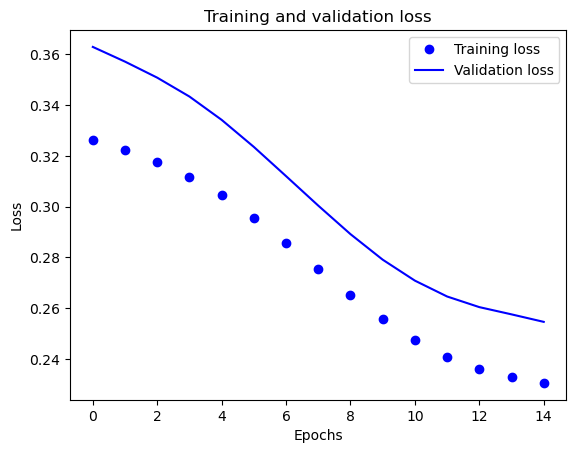

In [64]:
epochs = range(NUM_EPOCHS)

plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

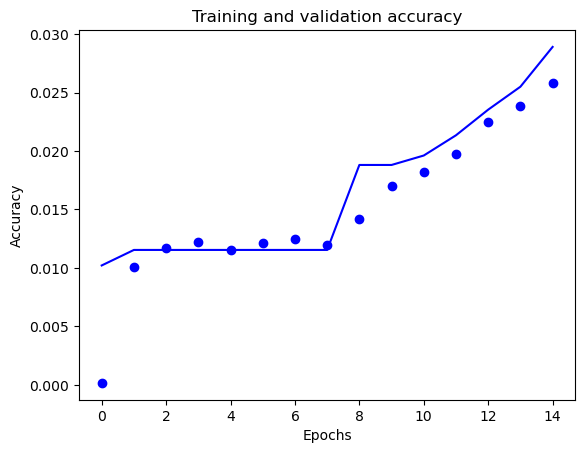

In [65]:
plt.plot(epochs, train_accs, 'bo', label='Training acc')
plt.plot(epochs, val_accs, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [73]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    # print(ys)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        # print(ys) # Remove the comment to understand the loop
        if next_word == 2:
            break
    return ys


In [ ]:
# import torch
# import torch.nn.functional as F

# def greedy_decode(model, src, src_mask, max_len, start_symbol, beam_size):
#     src = src.to(DEVICE)
#     src_mask = src_mask.to(DEVICE)

#     memory = model.encode(src, src_mask)
#     ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
#     beams = [(ys, 0)]  # (tokens, log probability)

#     for _ in range(max_len - 1):
#         candidates = []
#         for beam in beams:
#             tgt_mask = (generate_square_subsequent_mask(beam[0].size(0))
#                         .type(torch.bool)).to(DEVICE)
#             out = model.decode(beam[0], memory, tgt_mask)
#             out = out.transpose(0, 1)
#             prob = model.generator(out[:, -1])
#             topk_probs, topk_tokens = torch.topk(prob, beam_size)
#             for prob, token in zip(topk_probs.squeeze(), topk_tokens.squeeze()):
#                 token = token.unsqueeze(0) 
#                 token = token.unsqueeze(0)  
#                 candidates.append((torch.cat([beam[0], token], dim=0),
#                                    beam[1] + prob.log().item()))

#         candidates = sorted(candidates, key=lambda x: -x[1])[:beam_size]
#         beams = [c for c in candidates if c[0][-1].item() != EOS_IDX]

#         if not beams:
#             break

#     return beams[0][0]

In [74]:
text2codes(['Go!'], sp)[0].view(-1, 1)

tensor([[  1],
        [138],
        [  2]])

In [77]:
# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text2codes([src_sentence], sp)[0].view(-1, 1)
    print("SRC: ", src)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model, src, src_mask, max_len=num_tokens + 20, start_symbol=BOS_IDX).flatten()
    print("Targ: ", tgt_tokens)
    tgt_chars_specials = codes2text([tgt_tokens])
    tgt_chars = []
    for char in tgt_chars_specials:
        if char != '<s>' and char != '<\s>':
            tgt_chars += [char]
    tgt_chars = ''.join(tgt_chars)
    return tgt_chars


In [78]:
tgt_sent = translate(transformer, 'I drink water every day')
tgt_sent

SRC:  tensor([[ 1],
        [74],
        [ 2]])
Targ:  tensor([    1,     8,     8,     8, 34907,     2])


'▁"▁"▁""</s>'

In [84]:
tgt = translate(transformer, "The house at the end of my street is red")
print(tgt)

SRC:  tensor([[ 1],
        [85],
        [ 2]])
Targ:  tensor([1, 8, 8, 8, 2])
▁"▁"▁"</s>


In [80]:
print(sp.decode_ids([  1,    11,   467, 31921, 31921,     2]))

ooneELSELS


In [85]:
eng = ["I live in a big red house.", "The sun is very big and hot.", "Today it's very cold and windy!", "Would you like to have some salt for your pasta?", "You need glasses, beacause you can't see.", "My dog is eigth years old.", "I'm wearing pants and a shirt.", "It is a fire in the building.", "Do you like to study on your computer?", "The bus was very full today."]
cand = []

swe = ["Jag bor i ett stort rött hus.".split(), "Solen är väldigt stor och varm.".split(), "Idag är det väldigt kallt och blåsigt!".split(), "Vill du ha salt till din pasta?".split(), "Du behöver glasögon, för du kan inte se.".split(), "Min hund är är åtta år gammal".split(), "Jag har på mig byxor och en tröja.".split(), "Det är en eld i byggnaden".split(), "Gillar du att plugga på din dator?".split(), "Bussen är väldigt full idag.".split()]

for sent in eng:
    cand.append(translate(transformer, sent).split())

print(bleu_score(cand, swe))

SRC:  tensor([[ 1],
        [74],
        [ 2]])
Targ:  tensor([    1,     8,     8,     8, 34907,     2])
SRC:  tensor([[ 1],
        [85],
        [ 2]])
Targ:  tensor([1, 8, 8, 8, 2])
SRC:  tensor([[ 1],
        [85],
        [ 2]])
Targ:  tensor([1, 8, 8, 8, 2])
SRC:  tensor([[  1],
        [165],
        [  2]])
Targ:  tensor([1, 8, 8, 8, 2])
SRC:  tensor([[  1],
        [598],
        [  2]])
Targ:  tensor([1, 8, 8, 8, 2])
SRC:  tensor([[ 1],
        [69],
        [ 2]])
Targ:  tensor([1, 8, 8, 8, 2])
SRC:  tensor([[ 1],
        [74],
        [ 2]])
Targ:  tensor([    1,     8,     8,     8, 34907,     2])
SRC:  tensor([[ 1],
        [74],
        [ 2]])
Targ:  tensor([    1,     8,     8,     8, 34907,     2])
SRC:  tensor([[ 1],
        [73],
        [ 2]])
Targ:  tensor([    1,     8,     8,     8, 34907,     2])
SRC:  tensor([[ 1],
        [85],
        [ 2]])
Targ:  tensor([1, 8, 8, 8, 2])
0.0
